In [1]:
SEED = 42
from random import seed as py_seed
py_seed(SEED)
from numpy.random import seed as np_seed
np_seed(SEED)
from tensorflow import random as tf_random
tf_random.set_seed(SEED)

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import np_utils
from keras.models import load_model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random
from sklearn.model_selection import KFold, train_test_split

Using TensorFlow backend.


In [3]:
# Data comes from here. This should contain a bunch of folders of classes, each containing examples
DATA_PATH = Path('food-101-original-source/images')

# Get class (folder) names
classes = sorted([entry.name for entry in DATA_PATH.iterdir() if entry.is_dir()])

# Load list of filenames and classes, and convert to numpy array to allow array slicing
# For k-fold validation
dataset = np.array([
    (f"{clazz}/{entry.name}", clazz)
    for clazz in classes
    for entry in (DATA_PATH / clazz).iterdir()
])

In [4]:
# create data generators

# Rescale 0-255 to 0-1
RESCALE=1./255

# This type of data generator is used to train the model
train_datagen = ImageDataGenerator(
    rescale=RESCALE,
    # Factors used to control
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images

)

# This type of generator is used to test the model
test_datagen = ImageDataGenerator(
    rescale=RESCALE,
)



In [5]:
def create_model(input_shape, num_classes):
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(input_shape, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = RMSprop()

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [6]:
# Image data generator settings
TARGET_SIZE = (224,224)
COLOR_MODE = "rgb"
BATCH_SIZE = 64
CLASS_MODE = "categorical"


# Training settings
NUM_FOLDS = 5
VALIDATION_SPLIT = 0.1
NUM_EPOCHS = 5

# Create train and test dataset
d_train, d_test = train_test_split(dataset, test_size = VALIDATION_SPLIT)

# Extract train dataset
#d_train = dataset[train_index]
# Split train dataset to form train and validation dataset
d_train, d_val = train_test_split(dataset, test_size = VALIDATION_SPLIT)

# These are used to convert the filename,class pairs to dataframes
FILENAME_COL = "filename"
CLASS_COL = "class"
COLUMNS = [FILENAME_COL, CLASS_COL]
# Convert to dataframes
d_train = pd.DataFrame(d_train, columns = COLUMNS)
d_val = pd.DataFrame(d_val, columns = COLUMNS)

# Create training data generators
# Training image data generator
train_it = train_datagen.flow_from_dataframe(
    d_train,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = True,
    seed = SEED
)
# Validation image data generator
val_it = test_datagen.flow_from_dataframe(
    d_val,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = False,
)

# Perform training
# Build the model
input_shape = (*TARGET_SIZE,3)
num_classes = len(classes)
model = create_model(input_shape, num_classes)

# Train the model
history = model.fit(
    train_it,
    validation_data=val_it,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True
)



Found 90900 validated image filenames belonging to 101 classes.
Found 10100 validated image filenames belonging to 101 classes.
Epoch 1/5
1421/1421 [==============================] - 325s 229ms/step - loss: 3.3375 - accuracy: 0.2347 - val_loss: 3.2356 - val_accuracy: 0.2865
Epoch 2/5
1421/1421 [==============================] - 307s 216ms/step - loss: 2.9314 - accuracy: 0.3148 - val_loss: 3.2980 - val_accuracy: 0.2966
Epoch 3/5
1421/1421 [==============================] - 301s 212ms/step - loss: 2.8928 - accuracy: 0.3302 - val_loss: 3.3232 - val_accuracy: 0.3097
Epoch 4/5
1421/1421 [==============================] - 300s 211ms/step - loss: 2.8824 - accuracy: 0.3359 - val_loss: 3.4531 - val_accuracy: 0.3196
Epoch 5/5
1421/1421 [==============================] - 300s 211ms/step - loss: 2.8894 - accuracy: 0.3371 - val_loss: 3.2912 - val_accuracy: 0.3274


In [7]:
d_test = pd.DataFrame(d_test, columns = COLUMNS)

# Extract test dataset and convert to dataframe
#d_test = pd.DataFrame(dataset[test_index], columns = COLUMNS)
# Create test image data generator
test_it = test_datagen.flow_from_dataframe(
    d_test,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,11
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = False,
)
# Test
loss, accuracy = model.evaluate(test_it)

print(f"Test Accuracy: {accuracy * 100}%")

Found 10100 validated image filenames belonging to 101 classes.
158/158 [==============================] - 25s 159ms/step
Test Accuracy: 33.653464913368225%


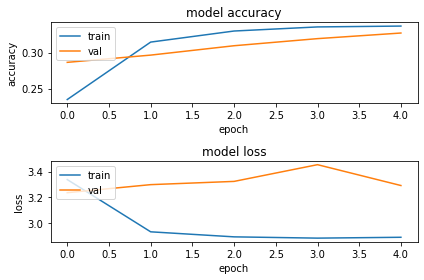

In [11]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()